# Keeping only mountains in the piemonte CTR

This is the piemonte CTR (Carta Tecnica Regionale) has mountains, elevation contour line, remarkable elevations, place names, and and paths.

We want to  try to keep only the montains.

First idea was to substract the ontour lines from another dataset but they never match exactly.

The next idea was to rely on steep slopes: keep only steep zones, relying on the DEM. 

Idealy, we want to keep only large zones to avoid artifacts, and want to make sure to enlarge the zones so as not to miss part of the mountain contour.

# Basic strategy

Here is a simple naive implementation based on GDAL.

Let's download our sample CTR and DEM, around Mont Malinvern as usual.
*Both use the same projection but the DEM covers a much larger area.*

In [65]:
cd ~/Downloads/dwnmaps/CTR_substract

/home/me/Downloads/dwnmaps/CTR_substract


In [66]:
#!wget http://www.datigeo-piem-download.it/static/regp01/CTR/CTR_raster_10.000_1991_1995-SDO_CTR_SEZIONI-225150-EPSG32632-TIF.zip
#!wget http://www.datigeo-piem-download.it/static/regp01/DTM5_ICE/RIPRESA_AEREA_ICE_2009_2011_DTM-SDO_CTR_FOGLI50-225-EPSG32632-TIF.zip

In [67]:
!gdalinfo DTM5_225.tif | grep -v '^    '  # UTM zone 32N ; pxl=5 ; 340890,4918000 + 5260x4600

Driver: GTiff/GeoTIFF
Files: DTM5_225.tif
Size is 5260, 4600
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
Data axis to CRS axis mapping: 1,2
Origin = (340890.000000000000000,4918000.000000000000000)
Pixel Size = (5.000000000000000,-5.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  340890.000, 4918000.000) (  7d 0' 7.40"E, 44d23'52.13"N)
Lower Left  (  340890.000, 4895000.000) (  7d 0'32.62"E, 44d11'27.13"N)
Upper Right (  367190.000, 4918000.000) (  7d19'55.75"E, 44d24'11.21"N)
Lower Right (  367190.000, 4895000.000) (  7d20'16.81"E, 44d11'46.07"N)
Center      (  354040.000, 4906500.000) (  7d10'13.14"E, 44d17'49.57"N)
Band 1 Block=5260x1 Type=Float32, ColorInterp=Gray
  NoData Value=-99


In [68]:
!gdalinfo CTR_s225150.TIF  # pxl=0.846666999999880 ; 353419,4901165 + 8008x6732


Driver: GTiff/GeoTIFF
Files: CTR_s225150.TIF
       CTR_s225150.TFW
Size is 8008, 6732
Origin = (353419.507666499994230,4901165.326333499513566)
Pixel Size = (0.846666999999880,-0.846666999999880)
Metadata:
  TIFFTAG_RESOLUTIONUNIT=2 (pixels/inch)
  TIFFTAG_SOFTWARE=IrfanView
  TIFFTAG_XRESOLUTION=300
  TIFFTAG_YRESOLUTION=300
Image Structure Metadata:
  COMPRESSION=CCITTFAX4
  INTERLEAVE=BAND
  MINISWHITE=YES
Corner Coordinates:
Upper Left  (  353419.508, 4901165.326) 
Lower Left  (  353419.508, 4895465.564) 
Upper Right (  360199.617, 4901165.326) 
Lower Right (  360199.617, 4895465.564) 
Center      (  356809.562, 4898315.445) 
Band 1 Block=8008x1 Type=Byte, ColorInterp=Palette
  Image Structure Metadata:
    NBITS=1
  Color Table (RGB with 2 entries)
    0: 255,255,255,255
    1: 0,0,0,255


In [69]:
!gdaldem slope DTM5_225.tif piemont-utm32n-slope-tile.tif

!cat > gdaldem-slope-binary40.clr <<EOF
  39  white
  41  0 0 0 0
  nv  white
EOF
!gdaldem color-relief -alpha -nearest_color_entry piemont-utm32n-slope-tile.tif gdaldem-slope-binary40.clr slopes40.tif
!gdaldem color-relief -nearest_color_entry piemont-utm32n-slope-tile.tif gdaldem-slope-binary40.clr slopes40noalpha.tif


SyntaxError: invalid syntax (<ipython-input-69-c4ef7f531050>, line 1)

Above, we build the slope model, and color it with a trick:
* slope > 40° is transpoarent
* slope < 40°is opaque white
This way we have a "mask" that we can see eg wih QGIS

*I couldn't find the correct GDAL incantation to merge. Something like:
```sh
gdalwarp -srcnodata "0 0 0" -te 340890 4918000 367190 4895000 CTR_s225150.TIF slopes40.tif tmp.tif
gdalwarp -overwrite -srcnodata "0 0 0" -te 340890 4895000 367190 4918000 CTR_s225150.TIF slopes40noalpha.tif tmp.tif
```

Probably easier would be to do the contrary (<40 transpoarent / >40 opaque)) and "apply" the alpha band (band 4) from slopes40.tif on CTR.tif 

Anyway, this first try is enough to confirm the feasibility of the strategy, but also to show that we need a smarter implementation.

## Smarter strategy

Something like,
* build a DEM with resolution reduced by x8, to 1px = 40m, using average. This filters features too smal, and makes remaining processing quicker.
* initialize output with 0
* loop though all pixels
* if pixel is already categorized (see below) skip it
* if pixel is > 40°, flag pixel and all adjacent pixels > 28° (iteratively) as mountain eg output = 1.
* otherwise flag as not-mountain ie keep output = 0.

Instead of implementating this manually, we can rely on the fact that is basically flood-filling an image with a tolerance, so there are existing tools like [skimage.segmentation.flood_fill](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html)
See especially the last example with [mask post-processing](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_floodfill.html#flood-fill-in-hsv-space-and-mask-post-processing)

The concept of using morphological closing to get rid of artifacts is explained [here](https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#closing)

In [ ]:
!pip install scikit-image >/dev/null

In [70]:
from PIL import Image
import numpy as np

impil = Image.open('piemont-utm32n-slope-tile.tif')
im = np.array(impil)
# reverse ^ with Image.fromarray(imarray)
im[:3,:3]

array([[-9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
       [-9.9990000e+03,  1.4190126e+01,  7.9519577e+00],
       [-9.9990000e+03,  2.5918724e+01,  2.3625069e+01]], dtype=float32)

In [71]:
!gdalwarp -overwrite -r average -tr 40 40 \
	piemont-utm32n-slope-tile.tif piemont-utm32n-slope-x8.tif

Creating output file that is 658P x 575L.
Processing piemont-utm32n-slope-tile.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image piemont-utm32n-slope-tile.tif.
Copying nodata values from source piemont-utm32n-slope-tile.tif to destination piemont-utm32n-slope-x8.tif.
...10...20...30...40...50...60...70...80...90...100 - done.


In [72]:
from PIL import Image
import numpy as np

impil = Image.open('piemont-utm32n-slope-x8.tif')
im = np.array(impil)
# reverse ^ with Image.fromarray(imarray)
print(im.size)
im[:3,:3]

378350


array([[19.212408, 14.357131, 12.700459],
       [25.073568, 24.768183, 13.745111],
       [15.671948, 12.085206, 18.315813]], dtype=float32)

In [73]:
impil.show()

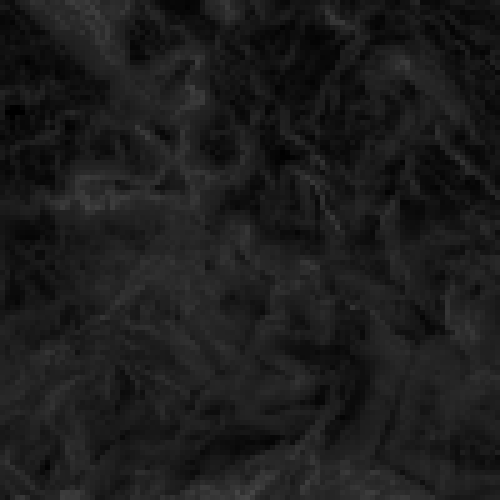

In [74]:
#impil.sddhow()

sample = im[:100, :100]

def imdebug(theim, zoom=1):
	w, h = theim.shape
	return Image.fromarray(theim).resize((w*zoom, h*zoom), Image.NEAREST).convert('RGB')

imdebug(sample, 5)

In [75]:
# the white triangle in the middle-top-left is monte Servagno
sample[1, 7]  # first whitish point at the top-left

42.020382

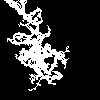

In [76]:
from skimage.segmentation import flood, flood_fill
imdebug(flood(sample, (1,7), tolerance=10), 1)

#abandoning flood as it's complicated to implement efficiently (ie without flooding every >40°pixel)

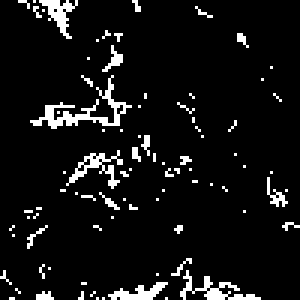

In [77]:
mask = sample > 43
mask[:9, :9]
imdebug(mask, 3)

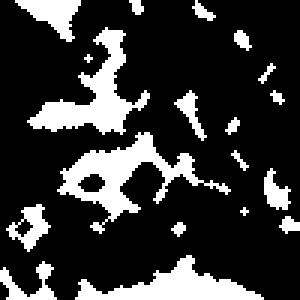

In [78]:
from skimage.morphology import erosion, dilation, disk

dilated = dilation(mask, disk(3))
eroded = erosion(dilated, disk(2))
imdebug(dilated, 3)
imdebug(eroded, 3)


In [79]:
mask[:1,:9]
mask.astype('uint8')[:1,:9]

array([[0, 0, 0, 0, 0, 0, 1, 1, 1]], dtype=uint8)

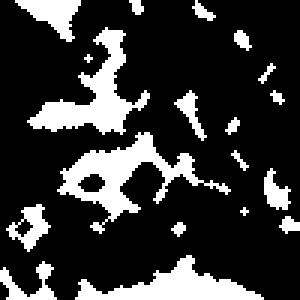

In [80]:
from skimage.filters.rank import maximum, minimum
dilated = maximum(mask.astype('uint8'), disk(3))
eroded = minimum(dilated, disk(2))

# dilated[:1,:9]
imdebug(eroded.astype(bool), 3)

Success!
Let's write this as an opacity (alpha) layer, so, negated


In [ ]:
def dem_to_mask(dempath='piemont-utm32n-slope-x8.tif'):
    from PIL import Image
    import numpy
    from skimage.morphology import erosion, dilation, disk
    
    impil = Image.open(dempath)
    im = numpy.array(impil)
    mask = im > 43
    footprint = disk(3)
    # https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#closing
    dilated = dilation(mask, footprint)
    eroded = erosion(dilated, disk(2))

    # https://github.com/python-pillow/Pillow/issues/3692
    outpath = "closed_" + dempath
    outpil = Image.fromarray(eroded).convert('P')  # convert to paletted because othewise garbage out
    outpil.save(outpath, compression='tiff_deflate', tiffinfo=impil.tag)
    return outpil


In [ ]:
eroded_all = dem_to_mask()
eroded_all.show()

In [ ]:
eroded_all.mode

#databytes = np.packbits(data, axis=1)

# import PIL
# import numpy as np
# print(np.array(PIL.Image.fromarray(np.eye(5, dtype=bool), mode='1')))
# print(PIL.Image.fromarray(np.eye(5, dtype=bool)).mode)
# print(PIL.Image.fromarray(np.eye(5, dtype=bool), mode='1').mode)
# PIL.Image.fromarray(np.eye(5, dtype=bool), mode='1')

In [ ]:
!display closed_piemont-utm32n-slope-x8.tif


display-im6.q16: Unknown field with tag 33550 (0x830e) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
display-im6.q16: Unknown field with tag 33922 (0x8482) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
display-im6.q16: Unknown field with tag 34735 (0x87af) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
display-im6.q16: Unknown field with tag 34737 (0x87b1) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.
display-im6.q16: Unknown field with tag 42113 (0xa481) encountered. `TIFFReadDirectory' @ warning/tiff.c/TIFFWarnings/985.


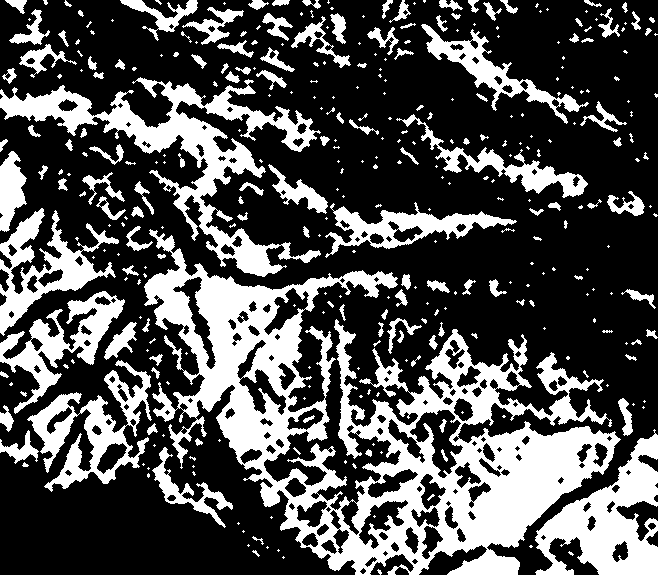

In [ ]:
eroded_all

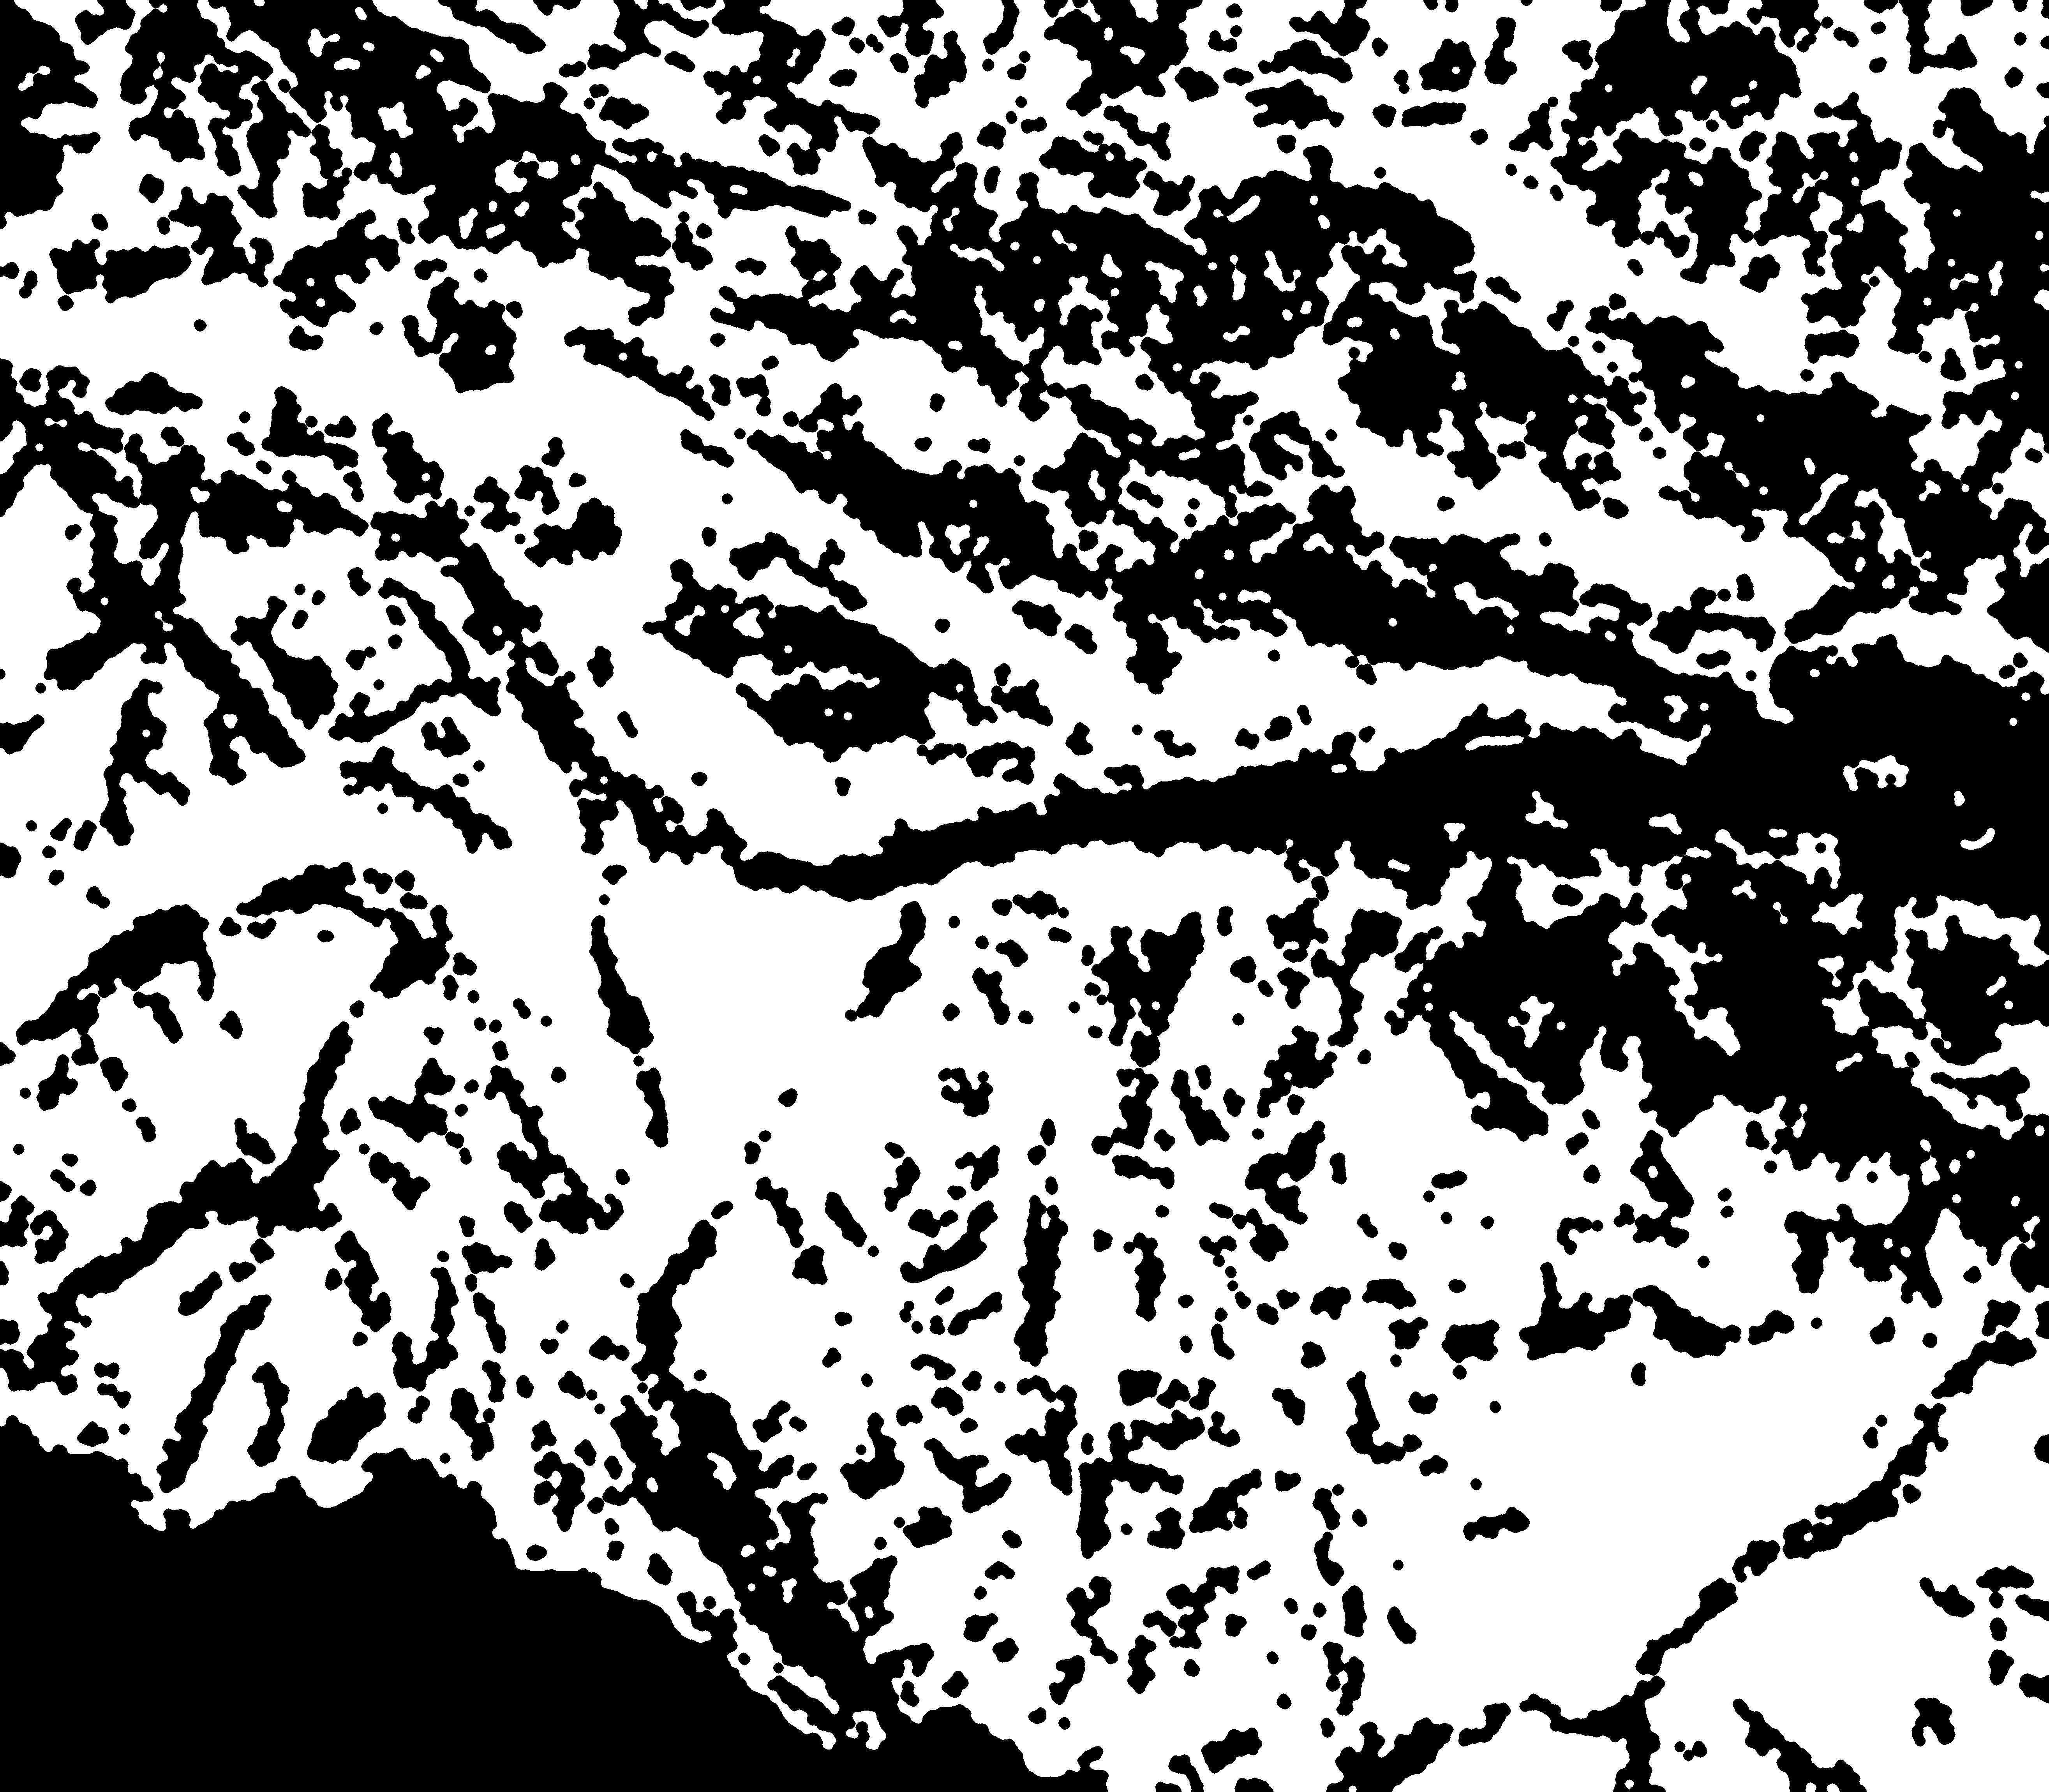

In [97]:
def dem_to_mask(dempath='piemont-utm32n-slope-tile.tif'):
    from PIL import Image
    import numpy as np
    from skimage.morphology import binary_erosion, binary_dilation, disk
    
    impil = Image.open(dempath)
    im = np.array(impil)
    mask = im > 40
    # https://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#closing
    # (A) remove small features
    dilated1 = binary_dilation(mask, disk(1))
    eroded1 = binary_erosion(dilated1, disk(2))
    # (B) don't leave small holes
    # 3 * 8 is much faster than 24 (cache effects?)
    dilated = binary_dilation(binary_dilation(binary_dilation(eroded1, disk(8)), disk(8)), disk(8))
    eroded = binary_erosion(binary_erosion(dilated, disk(7)), disk(7))

    # https://github.com/python-pillow/Pillow/issues/3692
    outpath = "closed_" + dempath
    outpil = Image.fromarray(eroded).convert('P')  # convert to paletted because othewise garbage out
    outpil.save(outpath, compression='tiff_deflate', tiffinfo=impil.tag)
    return outpil

eee = dem_to_mask()
eee

In [ ]:
!gdalinfo piemont-utm32n-slope-x8.tif | rg -v '    '

Driver: GTiff/GeoTIFF
Files: piemont-utm32n-slope-x8.tif
Size is 658, 575
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
Data axis to CRS axis mapping: 1,2
Origin = (340890.000000000000000,4918000.000000000000000)
Pixel Size = (40.000000000000000,-40.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  340890.000, 4918000.000) (  7d 0' 7.40"E, 44d23'52.13"N)
Lower Left  (  340890.000, 4895000.000) (  7d 0'32.62"E, 44d11'27.13"N)
Upper Right (  367210.000, 4918000.000) (  7d19'56.65"E, 44d24'11.22"N)
Lower Right (  367210.000, 4895000.000) (  7d20'17.71"E, 44d11'46.08"N)
Band 1 Block=658x3 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [102]:

!gdalinfo closed_piemont-utm32n-slope-tile.tif | rg -v '  [ 0-9]'

Driver: GTiff/GeoTIFF
Files: closed_piemont-utm32n-slope-tile.tif
Size is 5260, 4600
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 32N",
Data axis to CRS axis mapping: 1,2
Origin = (340890.000000000000000,4918000.000000000000000)
Pixel Size = (5.000000000000000,-5.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  COMPRESSION=DEFLATE
  INTERLEAVE=BAND
Corner Coordinates:
Band 1 Block=5260x12 Type=Byte, ColorInterp=Palette
  NoData Value=-9999
  Color Table (RGB with 256 entries)


In [ ]:

*I couldn't find the correct GDAL incantation to merge. Something like:
```sh
gdalwarp -srcnodata "0 0 0" -te 340890 4918000 367190 4895000 CTR_s225150.TIF slopes40.tif tmp.tif
gdalwarp -overwrite -srcnodata "0 0 0" -te 340890 4895000 367190 4918000 CTR_s225150.TIF slopes40noalpha.tif tmp.tif
```

Probably easier would be to do the contrary (<40 transpoarent / >40 opaque)) and "apply" the alpha band (band 4) from slopes40.tif on CTR.tif 

'P'